<a href="https://colab.research.google.com/github/YolandaNkalashe25/COS801/blob/main/COS_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install torch torchvision
import torch
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


In [2]:
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
import seaborn as sns
from matplotlib import pyplot


In [3]:
#Downloading data.
xy=pd.read_csv('/content/drive/My Drive/Colab Notebooks/COS801/fashion-mnist_train.csv')
xy_Test=pd.read_csv('/content/drive/My Drive/Colab Notebooks/COS801/fashion-mnist_test.csv')

In [4]:
col=xy.columns
X=xy[col[1:]]
Y=xy[col[0]]

In [5]:
#Splitting the xy into train and validation set:
x_train, x_val, y_train, y_val = train_test_split(X, Y, 
                                                    train_size=0.80, 
                                                    random_state=42)

In [6]:
x_train=x_train.to_numpy()
x_val=x_val.to_numpy()
y_train=y_train.to_numpy()
y_val=y_val.to_numpy()

In [ ]:
x_train

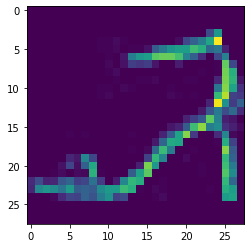

In [7]:
pyplot.imshow(x_train[0].reshape((28,28)))

In [8]:
# Convert numpy arrays to tensor

x_train, y_train  , x_val, y_val = map(torch.tensor, (x_train, y_train, x_val, y_val))

In [9]:
n, c= x_train.shape

In [10]:
input_features=784
output_size=10
hidden_size=0

In [11]:
#using the net class to randomly intilize the weightd
class Net(nn.Module):

  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(input_features, output_size)

  def forward(self, xb):
    xb = self.fc1(xb)
    return F.log_softmax(xb,dim=-1)

In [12]:
model=Net()


In [73]:
from torch.utils.data import TensorDataset
train_ds= TensorDataset(x_train, y_train)
Val_ds= TensorDataset(x_val, y_val)
test_ds=TensorDataset(x_val, y_val)

In [75]:
from torch.utils.data import DataLoader
train_dl=DataLoader(train_ds,batch_size=50)
Val_dl=DataLoader(Val_ds,batch_size=50)
test_dl=DataLoader(test_ds, batch_size=50)

In [15]:
#Optimizer to update the weights during backpropagation use stochatic gradient descent optimizer. We instantiate with our model parameters
optimizer = optim.SGD(model.parameters(),lr=0.01)

Loss_fn=nn.NLLLoss()


In [41]:
ephoch_data=[]
ephoc=1001

In [ ]:
for xb,yb in train_dl:
    xb=xb.type(torch.float)
    print(xb.dtype)

In [67]:
early_stop=False
min_val_loss=10000
min=[]
val_loss=0

In [68]:
#Start training for a 1000 ephocs.
#for every ephoc we zero out our gradients so that we have fresh gradients:
for ephoch in range(1,ephoc):
  
  for xb,yb in train_dl:
    xb=xb.type(torch.float)
    yb=yb.type(torch.long)
    Ypred=model(xb)  #We then perform a backward pass.The model only has a function for a forward pass.
    loss=Loss_fn(Ypred, yb)

    loss.backward()  ## Calculate the gradients once loss has been calculated.
    #Once gradients are calculated we need to update our parameters:
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
      for xbv,ybv in train_dl:
        xbv=xbv.type(torch.float)
        ybv=ybv.type(torch.long)
        Ypred_val=model(xbv)
        loss_val=Loss_fn(Ypred_val,ybv)
         
        val_loss += loss_val
        val_loss = val_loss / len(xbv)

        if val_loss < min_val_loss:
             min_val_loss = val_loss
             min.append(min_val_loss)
        else:
          early_stop=True
          break

        _,pred=Ypred_val.data.max(1) 
        
      accuracy =pred.eq(ybv.data).sum().item()/ybv.size()[0]

      ephoch_data.append([ephoch,loss.data.item(),loss_val.data.item(),accuracy])
 
  #for every 100 ephocs print out the data to screen

  if ephoch % 100==0:
    print('ephoc- %d (%d%%) train loss - %.2f validation loss - %.2f accuracy - %.4f'\
             % (ephoch, ephoch/150 * 10, loss.data.item(),loss_val.data.item(),accuracy))


ephoc- 100 (6%) train loss - 2236.42 validation loss - 629.98 accuracy - 0.8600
ephoc- 200 (13%) train loss - 441.30 validation loss - 855.55 accuracy - 0.8200
ephoc- 300 (20%) train loss - 1060.36 validation loss - 710.68 accuracy - 0.8600
ephoc- 400 (26%) train loss - 1347.55 validation loss - 1217.19 accuracy - 0.8000
ephoc- 500 (33%) train loss - 1775.46 validation loss - 523.08 accuracy - 0.8400
ephoc- 600 (40%) train loss - 746.23 validation loss - 1093.58 accuracy - 0.8000
ephoc- 700 (46%) train loss - 618.58 validation loss - 1015.69 accuracy - 0.8400
ephoc- 800 (53%) train loss - 633.32 validation loss - 1536.08 accuracy - 0.7800
ephoc- 900 (60%) train loss - 885.09 validation loss - 1224.37 accuracy - 0.8400
ephoc- 1000 (66%) train loss - 741.06 validation loss - 381.49 accuracy - 0.8800


In [69]:
df_ephocs_data=pd.DataFrame(ephoch_data, columns=["epoch","train_loss","validation_loss","accuracy"])

In [70]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show>

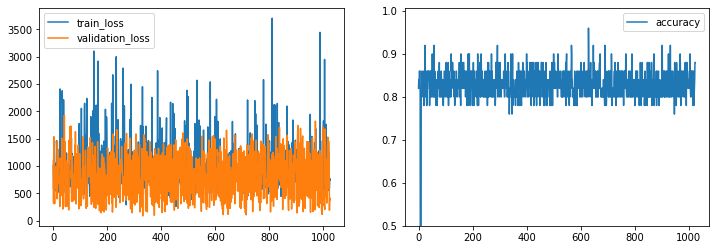

In [71]:
f, (ax1, ax2)=plt.subplots(1,2, figsize =(12,4))

df_ephocs_data[["train_loss","validation_loss"]].plot(ax=ax1)
df_ephocs_data[["accuracy"]].plot(ax=ax2)
plt.ylim(ymin=0.5)

plt.show


In [83]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() 

for X_test, Y_test in test_dl:
    if len(Y_test.data) != 50:
        break
    # forward pass: compute predicted outputs by passing inputs to the model
    X_test=X_test.type(torch.float)
    Ypred = model(X_test)
    # calculate the loss
    loss = Loss_fn(Ypred, Y_test)
    # update test loss 
    test_loss += loss.item()*X_test.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(Ypred, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(Ypred.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(50):
        label = Ypred.X_test[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_dl.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


RuntimeError: ignored

TypeError: ignored

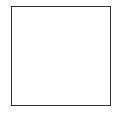

In [85]:
# obtain one batch of test images
dataiter = iter(test_dl)
images, labels = dataiter.next()

# get sample outputs
output = model(images.type(torch.float))
# convert output probabilities to predicted class
_, preds = torch.max(Ypred, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))